In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


# Statistiques descriptives

En première analyse et afin de se familiariser avec les données obtenues avec le datascraping, nous allons faire quelques statistiques descriptives sur notre base de données

In [96]:
import pandas as pd

# Charger le fichier CSV dans un DataFrame
df_questions = pd.read_csv('/Users/iokanaanbelfis-simon/PythonPourLaDataScience/Datascrapping/data_cleaned.csv', encoding='utf-8', sep='|')

# Afficher les premières lignes du DataFrame
df_questions.head()



,id,groupe,nom,ministère_interrogé,rubrique,titre,date,question,question_clean
0,1,"Libertés, Indépendants, Outre-mer et Territoires",M. Christophe Naegelen,Agriculture et souveraineté alimentaire,animaux,Cohabitation entre les randonneurs et les patous,05/07/2022,M. Christophe Naegelen interroge M. le ministr...,interroge agriculture souveraineté alimentaire...
1,2,Les Républicains,M. Pierre Cordier,Transition écologique et cohésion des territoires,chasse et pêche,Pratique de la vénerie sous terre pour la régu...,05/07/2022,M. Pierre Cordier appelle l'attention de Mme l...,appelle attention transition écologique cohési...
2,3,Démocrate (MoDem et Indépendants),M. Frédéric Petit,Armées,défense,Défense - Union européenne - SCAF - MGCS - coo...,05/07/2022,M. Frédéric Petit appelle l'attention de M. le...,appelle attention armées projets européens coo...
3,4,Renaissance,Mme Marie-Pierre Rixain,Comptes publics,eau et assainissement,Recouvrement des impayés de redevances d'assai...,05/07/2022,Mme Marie-Pierre Rixain appelle l'attention de...,appelle attention délégué auprès économie fina...
4,5,"Libertés, Indépendants, Outre-mer et Territoires",M. Christophe Naegelen,Éducation nationale et jeunesse,enseignement,Conditions d'embauche d'assistants d'éducation...,05/07/2022,M. Christophe Naegelen interroge M. le ministr...,interroge éducation nationale jeunesse décret ...


In [97]:
def compte_occurrences_par_valeur(data_frame, nom_colonne, valeurs_possibles):
    """
    Renvoie une liste avec le nombre d'occurrences de chaque valeur dans une colonne du DataFrame.

    Args:
    - data_frame (pd.DataFrame): Le DataFrame pandas.
    - nom_colonne (str): Le nom de la colonne pour laquelle compter les occurrences.
    - valeurs_possibles (list): Liste des valeurs possibles.

    Returns:
    - list: Liste du nombre d'occurrences pour chaque valeur.
    """
    if nom_colonne in data_frame.columns:
        occurrences = [data_frame[data_frame[nom_colonne] == valeur].shape[0] for valeur in valeurs_possibles]
        return occurrences
    else:
        raise ValueError(f"La colonne {nom_colonne} n'existe pas dans le DataFrame.")

# Répartition des questions par groupe politique

Pour débuter, nous allons nous interesser à la proportion de questions aux gouvernements écrites en fonction de l'appartenance à un groupe politique




['LibertÃ©s, IndÃ©pendants, Outre-mer et Territoires', 'Les RÃ©publicains', 'DÃ©mocrate (MoDem et IndÃ©pendants)', 'Renaissance', 'Gauche dÃ©mocrate et rÃ©publicaine - NUPES', 'La France insoumise - Nouvelle Union Populaire Ã©cologique et sociale', 'Rassemblement National', 'Horizons et apparentÃ©s', 'Ã\x89cologiste - NUPES', 'Socialistes et apparentÃ©s', 'Non inscrit']
<class 'list'>


/Users/iokanaanbelfis-simon/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


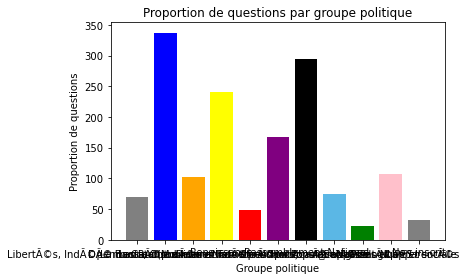

In [76]:
groupes_politiques = df_questions['groupe'].unique().tolist()
# liste qui comprend le nom de chaque groupe politique

nb_questions_gp_politique = compte_occurrences_par_valeur(df_questions, 'groupe', groupes_politiques)
# liste qui contient, pour chaque groupe politique, le nombre de questions posées présentes dans le dataframe)

print(groupes_politiques)
print(type(nb_questions_gp_politique))

import matplotlib.pyplot as plt

groupes_politiques = [str(element) for element in groupes_politiques]

#On définit une couleur bleu clair pour le groupe horizon

import colorsys

def obtenir_bleu_clair():
    """
    Retourne une couleur bleu clair au format hexadécimal.

    Returns:
    - str: Couleur bleu clair au format hexadécimal.
    """
    # Définir la teinte (H), la saturation (S), et la valeur (V)
    teinte_bleu_clair = 200  # Teinte bleu
    saturation = 0.6
    luminosite = 0.9

    # Convertir de HSV à RGB
    rgb_bleu_clair = colorsys.hsv_to_rgb(teinte_bleu_clair/360, saturation, luminosite)

    # Convertir de RGB à hexadécimal
    couleur_hex_bleu_clair = "#{:02X}{:02X}{:02X}".format(
        int(rgb_bleu_clair[0] * 255),
        int(rgb_bleu_clair[1] * 255),
        int(rgb_bleu_clair[2] * 255)
    )

    return couleur_hex_bleu_clair
couleur_bleu_clair = obtenir_bleu_clair()

couleurs_groupes = ['grey','blue', 'orange', 'yellow', 'red', 'purple','black', couleur_bleu_clair,'green','pink','grey','grey']
plt.bar(groupes_politiques, nb_questions_gp_politique, color=couleurs_groupes)
plt.xlabel('Groupe politique')
plt.ylabel('Proportion de questions')
plt.title('Proportion de questions par groupe politique')
plt.show()



# Répartition des question par thématique : rubrique et ministère

In [77]:
ministères = df_questions['ministère_interrogé'].unique().tolist()
# liste qui comprend le nom de chaque ministère auquel au moins une des questions contenues dans le DataFrame est adressée

nb_questions_ministère = compte_occurrences_par_valeur(df_questions, 'ministère_interrogé', ministères)
# liste qui contient, pour chaque ministère, le nombre de questions présentes dans le dataframe qui lui est adressée)

ministères = [str(element) for element in ministères]

import matplotlib.pyplot as plt

plt.bar(ministères, nb_questions_ministère, color= "blue")
plt.xlabel('Ministère')
plt.ylabel('Proportion de questions')
plt.title('Proportion de questions par ministère')
plt.show()

KeyError: 'ministère_interrogé'

In [78]:
data_frame = pd.DataFrame({'Ministère':ministères , 'Nombre de questions': nb_questions_ministère })
tableau = tabulate(data_frame, headers='keys', tablefmt='grid', showindex=False)
print(tableau)

NameError: name 'tabulate' is not defined

## Nuages de mots


In [8]:
pip install --upgrade pip
pip install --upgrade Pillow

pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [113]:
import wordcloud
import numpy as np
import io
import requests
import PIL
import matplotlib.pyplot as plt
import random



In [98]:
df_questions.head()

,id,groupe,nom,ministère_interrogé,rubrique,titre,date,question,question_clean
0,1,"Libertés, Indépendants, Outre-mer et Territoires",M. Christophe Naegelen,Agriculture et souveraineté alimentaire,animaux,Cohabitation entre les randonneurs et les patous,05/07/2022,M. Christophe Naegelen interroge M. le ministr...,interroge agriculture souveraineté alimentaire...
1,2,Les Républicains,M. Pierre Cordier,Transition écologique et cohésion des territoires,chasse et pêche,Pratique de la vénerie sous terre pour la régu...,05/07/2022,M. Pierre Cordier appelle l'attention de Mme l...,appelle attention transition écologique cohési...
2,3,Démocrate (MoDem et Indépendants),M. Frédéric Petit,Armées,défense,Défense - Union européenne - SCAF - MGCS - coo...,05/07/2022,M. Frédéric Petit appelle l'attention de M. le...,appelle attention armées projets européens coo...
3,4,Renaissance,Mme Marie-Pierre Rixain,Comptes publics,eau et assainissement,Recouvrement des impayés de redevances d'assai...,05/07/2022,Mme Marie-Pierre Rixain appelle l'attention de...,appelle attention délégué auprès économie fina...
4,5,"Libertés, Indépendants, Outre-mer et Territoires",M. Christophe Naegelen,Éducation nationale et jeunesse,enseignement,Conditions d'embauche d'assistants d'éducation...,05/07/2022,M. Christophe Naegelen interroge M. le ministr...,interroge éducation nationale jeunesse décret ...


In [99]:
questions = " ".join(df_questions["question_clean"])

def clean_text(text):
    text = text.lower() 
    text = " ".join(text.split())
    return text

questions = clean_text(questions)
questions

"interroge agriculture souveraineté alimentaire statut particulier patous communément appelés chiens berger dispositifs mis place permettre cohabitation randonneurs patous chiens berger protègent troupeaux considérés divaguant lorsqu' trouvent laisse distance maître loi n° 2005 157 23 février 2005 modifié article l. 211 23 code rural loi libère poursuite pénale divagation éleveur propriétaire chien affecté protection troupeau patous garde chien conduite études montré patous dangereux hommes chiens dressés dissuader non blesser cas agressions recensés forte part randonneurs inquiets croiser chiens panneaux informations présents montagne prévenir promeneurs donner consignes cas présence patous période estivale arrive laisse présager forte affluence randonneurs hautes-vosges massifs français intensifier prévention installation panneaux information randonneurs entrent zone patous présents opportun interpelle développement dispositifs permettant meilleure cohabitation randonneurs patous art

In [100]:
occurrences = WordCloud().process_text(questions)

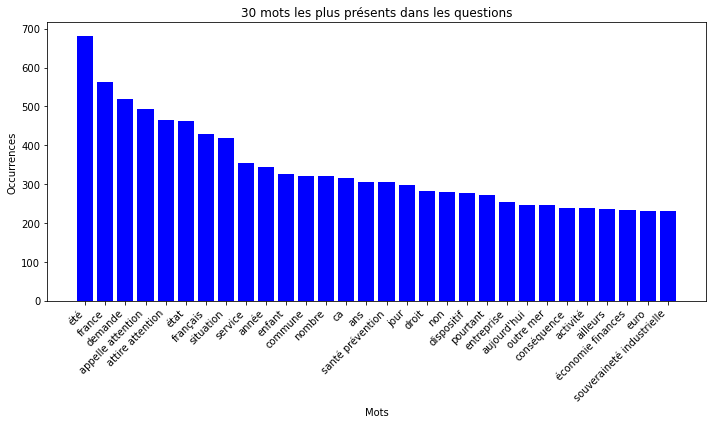

In [101]:
import matplotlib.pyplot as plt

def plot_top_n_keys(dictionary, n):
    # Sort the dictionary by values in descending order
    sorted_items = sorted(dictionary.items(), key=lambda x: x[1], reverse=True)

    # Take the top N items
    top_n_items = sorted_items[:n]

    # Extract keys and values for plotting
    keys, values = zip(*top_n_items)

    # Create a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(keys, values, color='blue')
    plt.xlabel('Mots')
    plt.ylabel('Occurrences')
    plt.title(f'{n} mots les plus présents dans les questions')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have a dictionary named 'word_count' from the previous example
plot_top_n_keys(occurrences, n=30)


(-0.5, 959.5, 865.5, -0.5)

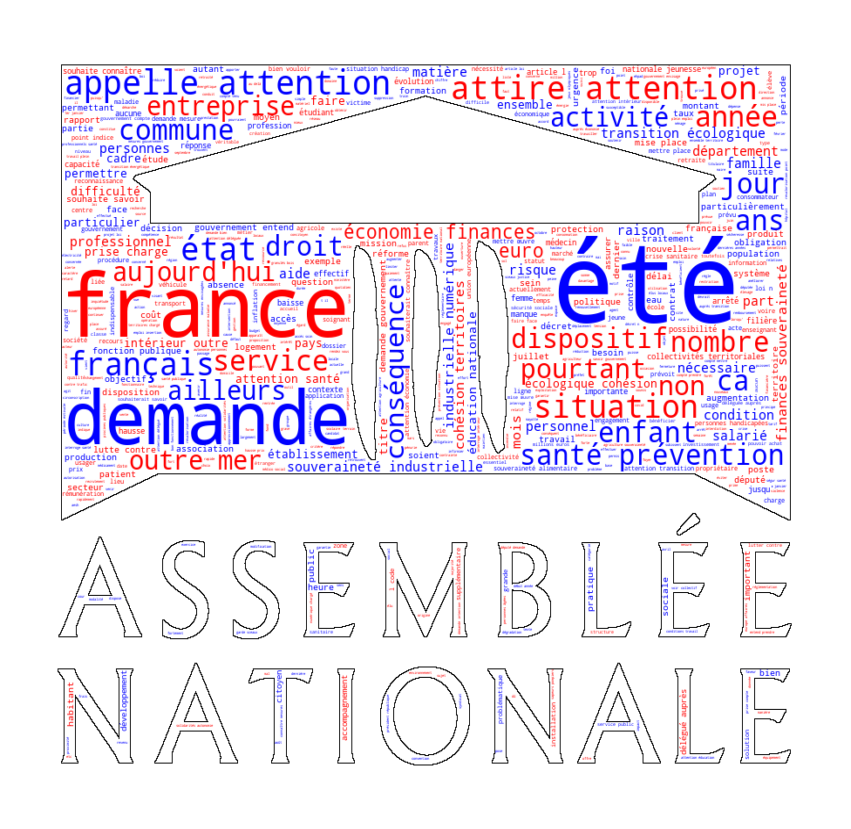

In [117]:


img = "https://upload.wikimedia.org/wikipedia/commons/a/ad/FRNationalAssemblyLogo.png"
an_mask = np.array(PIL.Image.open(io.BytesIO(requests.get(img).content)))

wc = wordcloud.WordCloud(background_color="white", max_words=200000, mask=an_mask, contour_width=0.1, contour_color='black').generate(questions)

def couleur(word, font_size, position, orientation, random_state=None, **kwargs):
    # Randomly choose between red and blue
    color = random.choice(['red', 'blue'])
    return color

plt.figure(figsize=(15, 15))
plt.imshow(wc.recolor(color_func=couleur), interpolation='bilinear', aspect='auto')
plt.axis("off")

